<h1><center>Titanic</center></h1>

<h1>1. Problem definition</h1>

In this notebook, I'll consider the problem of predicting survival on the Titanic using the Titanic dataset. It is based on a Kaggle competition called "Titanic - Machine Learning from Disaster". We are tackling with Classification problem, we will clean and analyze dataset, and then create machine learning model using scikit-learn library. This solution is created solely for educational purposes.

<h2>1.1 Preliminary assumptions</h2>

- PassengerId won't matter to the model, it only counts the number of passengers.
- Passenger wealth will help survival, so variables such as Pclass, Fare, Name (especially specific honors) and perhaps Ticket will matter to the model.
- The gender of the passenger will matter, in this type of disaster women are more likely to be rescued first, especially in the years of this disaster.
- The age of the passenger will matter, those who are young or older may have a higher survival rate.
- SibSp and Parch will matter, those with more siblings (especially children) on board will have a higher survival rate.
- Port of embarkation and cabin may matter because they can dictate location on the ship.
- Numbers in the Ticket variable are most likely useless, but letters may have some meaning.

<h1>2. Data preparation</h1>

<h3>Import packages</h3>

In [1]:
# data analysis and manipulation
import pandas as pd
import numpy as np

# data visualization and statistics
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

<h3>Load datasets</h3>

In [2]:
# load data from csv file into dataframe
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/train.csv')

<h3>Check the data</h3>

In [3]:
# print first five records
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have 12 variables, we will use the data dictionary from Kaggle*, which contains their descriptions. Here are some observations about them:
- PassangerId is a unique identifier for each passenger, it almost certainly does not carry any useful information. This is the first candidate for removal but we'll decide on it after closer examination.
- Survived is our target(dependent) variable, we want to create a model that predicts it.
- There are 5 independent variables that are categorical, namely Pclass, Sex, Cabin, Ticket and Embarked.
- Pclass is an ordinal variable, 1 is the first class, and so on.
- The ticket will require further investigation, and it is unclear whether it is unique and whether there is a pattern to it.
- Name variable contains honorifics.
- Embarked variable contains the abbreviation of Embarkation cities.
- Cabin variable contains empty values, as well as letters, this will also require further investigation.

*https://www.kaggle.com/competitions/titanic/data

<h2>2.1 Data cleaning</h2>

<h3>Identify columns that contain zero or very few values</h3>

In [4]:
# get the Series of numbers of unique values
unique_values_series = train.nunique()

# iterate through the Series and calculate unique values as a percentage of all values
for i, v in unique_values_series.items():
    percentage = v / train.shape[0] * 100
    print('%s: %d, %.2f%%' % (i, v, percentage))

PassengerId: 891, 100.00%
Survived: 2, 0.22%
Pclass: 3, 0.34%
Name: 891, 100.00%
Sex: 2, 0.22%
Age: 88, 9.88%
SibSp: 7, 0.79%
Parch: 7, 0.79%
Ticket: 681, 76.43%
Fare: 248, 27.83%
Cabin: 147, 16.50%
Embarked: 3, 0.34%


Key observations:
- PassengerId and Name are unique, PassengerId seems to have no predictive power, so we will drop it.
- Name contains titles, which we will extract, they may have predictive power, so we will leave them.
- Survived is our target variable, so we will leave it.
- Pclass, Sex, Embarked, SibSp, Parch are categorical variables, so it is obvious that their percentage is low
- Age and Fare need some more investigation, we will check their variance, but first we will need to get more knowledge about them.
- Ticket and Cabin need some simplifications, they have too many unique values.

<h3>Identify rows that contain duplicate data</h3>

In [5]:
# check dataset for duplicates
dups = train.duplicated()
print(dups.any())

False


Dataset contains no duplicates.

<h3>Identify outliers</h3>

<b>SibSp and Parch</b>

In [6]:
print(train['SibSp'].unique(), train['Parch'].unique())

[1 0 3 4 2 5 8] [0 1 2 5 3 4 6]


There do not seem to be any unlikely observations.

<b>Age</b>

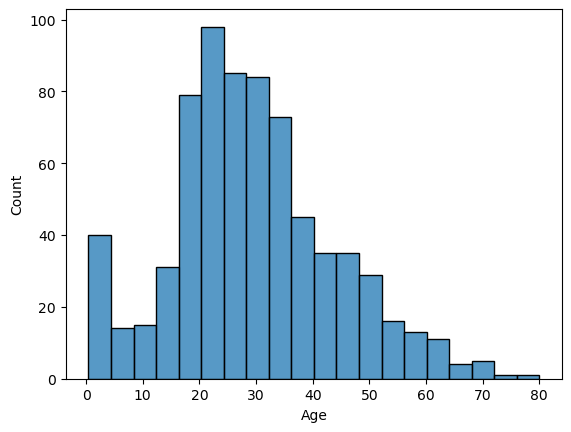

In [7]:
# Age histogram
sns.histplot(data=train, x='Age');

There also do not seem to be any unlikely observations. Elder people could also be on the ship.

<b>Fare</b>

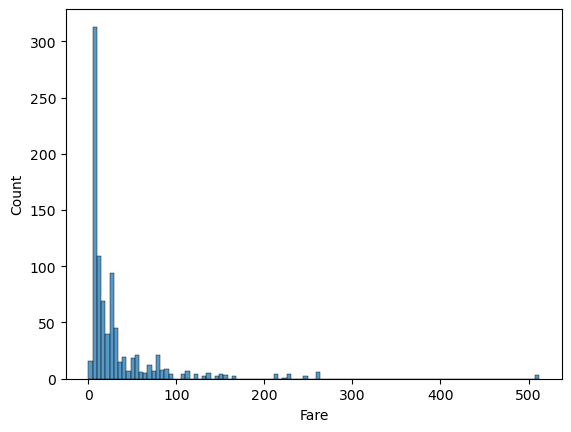

In [9]:
# Fare histogram
sns.histplot(data=train, x='Fare');

There seem to be some problems, we have most of the data in the 0-200 range, some data is also in the 200-300 range and some observations is in the 500+ range. Let's check our outliers.

In [20]:
# 200-300
outliers_group = train[(train['Fare'] > 200) & (train['Fare'] < 300)]

# 300+
possible_anomalies = train[train['Fare'] > 300]

display(outliers_group)
display(possible_anomalies)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
380,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
527,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


The last three seem strange at first glance, but may be true, as they all have the same ticket number, the same Pclass and port of embarkation, which may mean they are in the same very luxury cabin.

Rest of the variables are categorical and so they rather can't contain outliers.

<h3>Mark and remove missing data</h3>

In [37]:
# count empty data in each variable
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64